
# Associate Ca2+ signal with spindles for each session & subsessions using crossregistration

Load packages

In [1]:
cd "C:/Users/Manip2/SCRIPTS/Code python audrey/code python aurelie/interfaceJupyter/minian"

C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian


In [2]:
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy.interpolate import interp2d
from scipy.signal import find_peaks
import pickle
import os
from scipy.interpolate import griddata
from scipy.signal import find_peaks
import logging
from ast import literal_eval

%matplotlib widget

from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer
from IPython.display import display
from ipyfilechooser import FileChooser


from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

Load sleep score and Ca2+ time series numpy arrays

In [3]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath ="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Folder with videos</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

In [40]:
folder_base = Path(dpath)

nb_sessions = sum(1 for p in folder_base.iterdir() if p.is_dir() and p.name.startswith("session"))

try:
    mfile = open(folder_base / f'mappingsAB.pkl', 'rb')
    mapping = pickle.load(mfile)
    print('mappingsAB.pkl opened')
except:
    mfile = open(folder_base / f'mappings.pkl', 'rb')
    mapping = pickle.load(mfile)
    print('mappings.pkl opened')

sessions = []
subsessions = []
nb_minian_total=0
dict_Calcium = {}
dict_Spike = {}
dict_SWRprop = {}
dict_Spindleprop_PFC = {}
dict_Spindleprop_S1 = {}
dict_Stamps = {}
dict_StampsMiniscope = {}
dict_TodropFile = {}

for y in range(1, nb_sessions+1):
    session= 'session' + str(y)
    print(session)
    sessions.append(session)
    folder_mini = folder_base / f'session{y}/V4_Miniscope'
    nb_subsessions = sum(1 for p in folder_mini.iterdir() if p.is_dir() and p.name.startswith("session"))
    SWRproperties = folder_base / f'session{y}/OpenEphys/SWRproperties_AB.csv'
    Spindleproperties_PFC = folder_base / f'session{y}/OpenEphys/Spindlesproperties_PFC_AB.csv'
    Spindleproperties_S1 = folder_base / f'session{y}/OpenEphys/Spindlesproperties_S1_AB.csv'
    StampsFile = folder_base / f'session{y}/SynchroFile.xlsx'
    StampsMiniscopeFile = folder_mini / f'timeStamps.csv'
    if nb_subsessions!=0:
        for x in range(1, nb_subsessions+1):            
            subsession= "session"  + str(y) + str(x)
            subsessions.append(subsession)    
            minian_ds = open_minian(folder_mini / subsession / f'minian')      # OR minianAB
            dict_Calcium[subsession] = minian_ds['C'] # calcium traces 
            dict_Spike[subsession] = minian_ds['S'] # estimated spikes
            dict_SWRprop[subsession]  = pd.read_csv(SWRproperties)
            dict_Spindleprop_PFC[subsession]  = pd.read_csv(Spindleproperties_PFC)
            dict_Spindleprop_S1[subsession]  = pd.read_csv(Spindleproperties_S1)
            dict_Stamps[subsession]  = pd.read_excel(StampsFile)
            dict_StampsMiniscope[subsession]  = pd.read_csv(StampsMiniscopeFile)
            try:
                TodropFile = folder_mini / subsession / f'minian/TodropFileAB.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)
                    dict_TodropFile[subsession]  = unit_to_drop
            except:
                TodropFile = folder_mini / subsession / f'minian/TodropFile.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)
                    dict_TodropFile[subsession]  = unit_to_drop
            nb_minian_total+=1
            print(nb_minian_total)
    else:
        minian_ds = open_minian(folder_mini / f'minian')            # OR minianAB
        dict_Calcium[session] = minian_ds['C'] # calcium traces 
        dict_Spike[session] = minian_ds['S'] # estimated spikes
        dict_SWRprop[session]  = pd.read_csv(SWRproperties)
        dict_Spindleprop_PFC[session]  = pd.read_csv(Spindleproperties_PFC)
        dict_Spindleprop_S1[session]  = pd.read_csv(Spindleproperties_S1)
        dict_Stamps[session]  = pd.read_excel(StampsFile)
        dict_StampsMiniscope[session]  = pd.read_csv(StampsMiniscopeFile)
        try:
            TodropFile = folder_mini / f'minian/TodropFileAB.json'
            with open(TodropFile, 'r') as f:
                unit_to_drop = json.load(f)
                dict_TodropFile[session]  = unit_to_drop
        except:
            TodropFile = folder_mini / f'minian/TodropFile.json'
            with open(TodropFile, 'r') as f:
                unit_to_drop = json.load(f)
                dict_TodropFile[session]  = unit_to_drop
        nb_minian_total+=1  
        print(nb_minian_total)

mappingsAB.pkl opened
session1


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

1
session2


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

2
session3


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

3


Cross registration results

In [5]:
mapping

session                   variable                 group
   session1 session2 session3 distance                 group
0     172.0     29.0      NaN      NaN  (session1, session2)
1     205.0     36.0      NaN      NaN  (session1, session2)
2     227.0     38.0      NaN      NaN  (session1, session2)
3     182.0     34.0      NaN      NaN  (session1, session2)
4     109.0     11.0      NaN      NaN  (session1, session2)
5     167.0     28.0      NaN      NaN  (session1, session2)
6       NaN      0.0      NaN      NaN           (session2,)
7       NaN     33.0      NaN      NaN           (session2,)
8       NaN      2.0      NaN      NaN           (session2,)
9       NaN      3.0      NaN      NaN           (session2,)
10      NaN     12.0      NaN      NaN           (session2,)
11      NaN     14.0      NaN      NaN           (session2,)
12      NaN     15.0      NaN      NaN           (session2,)
13      NaN     16.0      NaN      NaN           (session2,)
14      NaN     55.0      NaN      NaN           (session2,)
15      NaN     56.0      NaN      NaN           (session2,)
16      NaN     30.0      NaN      NaN           (session2,)
17      NaN     31.0      NaN      NaN           (session2,)
18      NaN      NaN     64.0      NaN           (session3,)
19      NaN      NaN     22.0      NaN           (session3,)
20      NaN      NaN     39.0      NaN           (session3,)
21      NaN      NaN     45.0      NaN           (session3,)
22      NaN      NaN    142.0      NaN           (session3,)

In [6]:
B = mapping['session']
if os.path.basename(folder_base) == 'Purple':
    index = B.columns
    B.columns = index.str.replace('part', 'session2')
        
for c in range(len(B)):
    print('unit n°', c)
    for sess in list(dict_Stamps.keys()):
        print('= unit', int(B[sess][c]), 'in', sess) if math.isnan (float(B[sess][c])) == False else None

unit n° 0
= unit 172 in session1
= unit 29 in session2
unit n° 1
= unit 205 in session1
= unit 36 in session2
unit n° 2
= unit 227 in session1
= unit 38 in session2
unit n° 3
= unit 182 in session1
= unit 34 in session2
unit n° 4
= unit 109 in session1
= unit 11 in session2
unit n° 5
= unit 167 in session1
= unit 28 in session2
unit n° 6
= unit 0 in session2
unit n° 7
= unit 33 in session2
unit n° 8
= unit 2 in session2
unit n° 9
= unit 3 in session2
unit n° 10
= unit 12 in session2
unit n° 11
= unit 14 in session2
unit n° 12
= unit 15 in session2
unit n° 13
= unit 16 in session2
unit n° 14
= unit 55 in session2
unit n° 15
= unit 56 in session2
unit n° 16
= unit 30 in session2
unit n° 17
= unit 31 in session2
unit n° 18
= unit 64 in session3
unit n° 19
= unit 22 in session3
unit n° 20
= unit 39 in session3
unit n° 21
= unit 45 in session3
unit n° 22
= unit 142 in session3


In [7]:
# Define functions

def Convert(string):
    li = list(string.split(", "))
    li2 = len(li)
    return li2

def take_closest(myList, myNumber):        
    #Assumes myList is sorted. Returns closest value to myNumber.
    #If two numbers are equally close, return the smallest number.        
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return len(myList)
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def take_closest2(myList, myNumber):
    value2 = 10000000
    for ind in range(len(myList)):
        value = abs(myList[ind]-myNumber)
        if value < value2:
            value2 = value
            index = myList[ind]
    return index

def take_closest3(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        dummy = myList.index(after)
        return dummy
    else:
        dummy = myList.index(before)
        return dummy

def is_between(myList, starttime, endtime):
    IsTrue='False'
    for ind in range(len(myList)):
        if starttime <= myList[ind] <= endtime:
            IsTrue='True'
    return IsTrue

def is_overlapping(starttime, endtime, starttimeList, endtimeList):
    IsTrue='False'
    for ind in range(len(starttimeList)):
        if starttime<=starttimeList[ind] and starttimeList[ind]<=endtime: # event n°2 begins after the start n°1               
            if (endtime-starttimeList[ind])>=int(0.5*(endtime-starttime)): # overlapp > to 50% of the duration of the event n°1
                IsTrue='True'
        elif starttime<=endtimeList[ind] and endtimeList[ind]<=endtime: # event n°2 ends before the end n°1 
            if (endtimeList[ind]-starttime)>=int(0.5*(endtime-starttime)): # overlapp > to 50% of the duration of the event n°1
                IsTrue='True'
    return IsTrue

# Detect Overlapping Spindles

for session in sessions:
    listSpdlPFC= dict_Spindleprop_PFC[session]
    listSpdlS1= dict_Spindleprop_S1[session]
    listSpdlPFCstarts=listSpdlPFC["start time"]
    listSpdlPFCends=listSpdlPFC["end time"]
    listSpdlS1starts=listSpdlS1["start time"]
    listSpdlS1ends=listSpdlS1["end time"]
    for ss in range(len(listSpdlPFCstarts)): # for PFC 
        startPFC=listSpdlPFCstarts[ss]
        endPFC=listSpdlPFCends[ss]
        Istrue=is_overlapping(startPFC, endPFC, listSpdlS1starts, listSpdlS1ends)
        listSpdlPFC.loc[ss, 'GlobalSpindle'] =Istrue
    dict_Spindleprop_PFC[session]=listSpdlPFC
    filenameOut = folder_base /session / f'OpenEphys/Spindlesproperties_PFC_sd5bis_AB.xlsx'
    print(filenameOut)
    writer = pd.ExcelWriter(filenameOut)
    dict_Spindleprop_PFC[session].to_excel(writer)
    writer.close()
    for ss in range(len(listSpdlS1starts)): # for S1 
        startS1=listSpdlS1starts[ss]
        endS1=listSpdlS1ends[ss]
        Istrue=is_overlapping(startS1, endS1, listSpdlPFCstarts, listSpdlPFCends)
        listSpdlS1.loc[ss, 'GlobalSpindle'] =Istrue       
    dict_Spindleprop_S1[session]=listSpdlS1
    filenameOut = folder_base /session / f'OpenEphys/Spindlesproperties_S1_sd5bis_AB.xlsx'
    print(filenameOut)
    writer = pd.ExcelWriter(filenameOut)
    dict_Spindleprop_S1[session].to_excel(writer)
    writer.close()


\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recording_ABmodified\GreenDotsOK\session1\OpenEphys\Spindlesproperties_PFC_sd5bis_AB.xlsx
\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recording_ABmodified\GreenDotsOK\session1\OpenEphys\Spindlesproperties_S1_sd5bis_AB.xlsx
\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recording_ABmodified\GreenDotsOK\session2\OpenEphys\Spindlesproperties_PFC_sd5bis_AB.xlsx
\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recording_ABmodified\GreenDotsOK\session2\OpenEphys\Spindlesproperties_S1_sd5bis_AB.xlsx
\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recording_ABmodified\GreenDotsOK\session3\OpenEphys\Spindlesproperties_PFC_sd5bis_AB.xlsx
\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recording_ABmodified\GreenDotsOK\session3\

Distribute Ca2+ intensity & spikes to vigilance state for each sessions/subsessions

In [39]:
CortexList= ['PFC', 'S1']

for Cortex in CortexList:

    data = {}        
    before = 1000 # Max distance in ms between a SWR and a spindle to be considered as Precoupled
    after = 1000 # Max distance in ms between a spindle and a SWR to be considered as Postcoupled
    durationSpdl = 2 # number of sec before and after the Spdl onset taken into acount
    durationSWR = 0.5 # number of sec before and after the Spdl onset taken into acount
    counter=0
    counter2=0

    norm_freq=20 # final miniscope frequency used for all recordings

    Spindles_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','SpdlStatut','SpdlNumber','SpdlDuration (ms)','SWR inside Spdl','GlobalSpindle','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityAfter'])
    SWR_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','SWRStatut','SWRNumber','SWRDuration (ms)','SWR inside Spdl','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityAfter'])

    dict_All_ActivityCa_spin={}
    dict_All_ActivityCa_spin_Precoupled={}
    dict_All_ActivityCa_spin_Postcoupled={}
    dict_All_ActivityCa_spin_Uncoupled={}

    dict_All_ActivityCa_GlobalSpdl={}
    dict_All_ActivityCa_LocalSpdl={}

    dict_All_ActivityCa_swr={}
    dict_All_ActivityCa_swr_Precoupled={}
    dict_All_ActivityCa_swr_Postcoupled={}
    dict_All_ActivityCa_swr_Uncoupled={}

    dict_All_ActivitySp_spin={}
    dict_All_ActivitySp_spin_Precoupled={}
    dict_All_ActivitySp_spin_Postcoupled={}
    dict_All_ActivitySp_spin_Uncoupled={}

    dict_All_ActivitySp_GlobalSpdl={}
    dict_All_ActivitySp_LocalSpdl={}

    dict_All_ActivitySp_swr={}
    dict_All_ActivitySp_swr_Precoupled={}
    dict_All_ActivitySp_swr_Postcoupled={}
    dict_All_ActivitySp_swr_Uncoupled={}

    previousEndTime=0
    InitialStartTime=0

    for session in sessions: #i in list(dict_Stamps.keys()):    
        cPreCoupled=0
        cPostCoupled=0
        cUnCoupled=0
        cGlobal=0
        cLocal=0

        cPreCoupledSWR=0
        cPostCoupledSWR=0
        cUnCoupledSWR=0
        
        # Start time & freq miniscope

        StartTime = list(dict_Stamps[session][0])[0] # in seconds
        minian_freq=list(dict_Stamps[session][0])[2] # in Hz

        if minian_freq>=20: # should only remove 1 session                

            C=dict_Calcium[session]
            Cupd = C.loc[:, :]
            rec_dur = Cupd.shape[1]
            S=dict_Spike[session] 
            Supd = S.loc[:, :] 

            # Adjust the StartTime if subsessions

            if InitialStartTime==0:
                InitialStartTime=StartTime    
            else:
                if StartTime == InitialStartTime:
                    StartTime = previousEndTime + 1/minian_freq #  +1 frame in seconds 
                else:  
                    InitialStartTime=StartTime   

            # Deal with dropped frames (failure to acquire miniscope images)

            list_droppedframes = literal_eval(dict_Stamps[session][0][3])    

            numbdropfr= 0   
            upd_rec_dur=rec_dur
            droppedframes_inrec=[]
            for item in list_droppedframes: 
                if item < (int(StartTime*minian_freq) + upd_rec_dur) and item > int(StartTime*minian_freq):
                    droppedframes_inrec.append(item)
                    upd_rec_dur+=1 #add the dropped frame to the recording length
                    numbdropfr+=1                        

            EndTime = StartTime + ((rec_dur + numbdropfr)/minian_freq) # in seconds
            previousEndTime=EndTime     

            print(session, ': starts at', round(StartTime,1), 's & ends at', round(EndTime,1), 's (', round((rec_dur + numbdropfr)/minian_freq,1), 's duration, ', numbdropfr, 'dropped frames, minian frequency =', minian_freq, ')...') 
            
            # Remove bad units from recordings

            AA = C['unit_id']
            copyAA = list(AA.copy())
            unit_to_drop=dict_TodropFile[session]    
            for u in unit_to_drop:
                copyAA.remove(u)
            unit_to_keep = copyAA
            Cupd = Cupd.loc[unit_to_keep,:]
            Supd = Supd.loc[unit_to_keep,:]
            nb_unit = Cupd.shape[0]
            units = range(nb_unit)
                            
            C_upd_unit_id = Cupd['unit_id'].values
            kept_uniq_unit_List=[]
            for unit in units:
                indexMapp = np.where(B[session] == C_upd_unit_id[unit])[0]
                kept_uniq_unit_List.append(str(indexMapp))

            sentence1= f"... kept values = {kept_uniq_unit_List}"
            print(sentence1) 
            
            Carray = Cupd.values.T
            CarrayI = Cupd.values.T
            Sarray = Cupd.values.T

            for droppedframe in droppedframes_inrec: 
                print(droppedframe)
                print(Carray.shape, 'before')
                row_to_repeat = Carray[droppedframe]  
                Carray = np.vstack((Carray[:droppedframe], row_to_repeat, Carray[droppedframe:]))
                print(Carray.shape, 'after')

                if session=='session1':
                    CarrayI1=CarrayI
                    Carray1=Carray


session1 : starts at 149.0 s & ends at 1938.9 s ( 1790.0 s duration,  29 dropped frames, minian frequency = 30 )...
... kept values = ['[4]', '[5]', '[3]', '[1]', '[2]']
5662
(53670, 5) before
(53671, 5) after
19344
(53671, 5) before
(53672, 5) after
21984
(53672, 5) before
(53673, 5) after
23815
(53673, 5) before
(53674, 5) after
26005
(53674, 5) before
(53675, 5) after
26006
(53675, 5) before
(53676, 5) after
26442
(53676, 5) before
(53677, 5) after
26443
(53677, 5) before
(53678, 5) after
26444
(53678, 5) before
(53679, 5) after
28208
(53679, 5) before
(53680, 5) after
30397
(53680, 5) before
(53681, 5) after
32590
(53681, 5) before
(53682, 5) after
32593
(53682, 5) before
(53683, 5) after
34798
(53683, 5) before
(53684, 5) after
38099
(53684, 5) before
(53685, 5) after
38100
(53685, 5) before
(53686, 5) after
39209
(53686, 5) before
(53687, 5) after
39211
(53687, 5) before
(53688, 5) after
41418
(53688, 5) before
(53689, 5) after
43639
(53689, 5) before
(53690, 5) after
43641
(5369

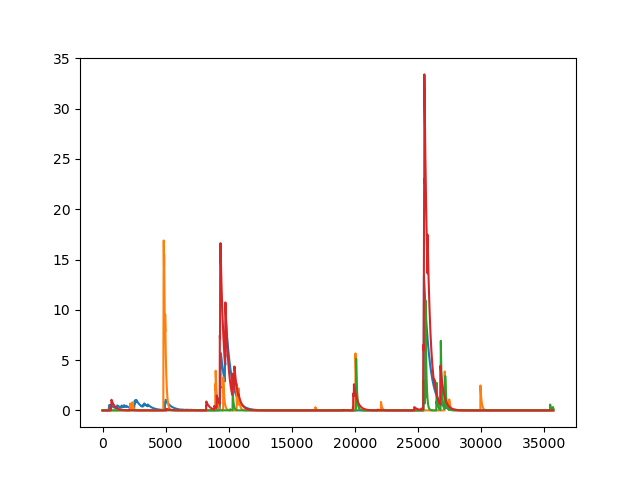

In [31]:
plt.close()
plt.plot(Carray)
plt.show()
#25319

In [19]:
CortexList= ['PFC', 'S1']

for Cortex in CortexList:

    data = {}        
    before = 1000 # Max distance in ms between a SWR and a spindle to be considered as Precoupled
    after = 1000 # Max distance in ms between a spindle and a SWR to be considered as Postcoupled
    durationSpdl = 2 # number of sec before and after the Spdl onset taken into acount
    durationSWR = 0.5 # number of sec before and after the Spdl onset taken into acount
    counter=0
    counter2=0

    norm_freq=20 # final miniscope frequency used for all recordings

    Spindles_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','SpdlStatut','SpdlNumber','SpdlDuration (ms)','SWR inside Spdl','GlobalSpindle','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityAfter'])
    SWR_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','SWRStatut','SWRNumber','SWRDuration (ms)','SWR inside Spdl','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityAfter'])

    dict_All_ActivityCa_spin={}
    dict_All_ActivityCa_spin_Precoupled={}
    dict_All_ActivityCa_spin_Postcoupled={}
    dict_All_ActivityCa_spin_Uncoupled={}

    dict_All_ActivityCa_GlobalSpdl={}
    dict_All_ActivityCa_LocalSpdl={}

    dict_All_ActivityCa_swr={}
    dict_All_ActivityCa_swr_Precoupled={}
    dict_All_ActivityCa_swr_Postcoupled={}
    dict_All_ActivityCa_swr_Uncoupled={}

    dict_All_ActivitySp_spin={}
    dict_All_ActivitySp_spin_Precoupled={}
    dict_All_ActivitySp_spin_Postcoupled={}
    dict_All_ActivitySp_spin_Uncoupled={}

    dict_All_ActivitySp_GlobalSpdl={}
    dict_All_ActivitySp_LocalSpdl={}

    dict_All_ActivitySp_swr={}
    dict_All_ActivitySp_swr_Precoupled={}
    dict_All_ActivitySp_swr_Postcoupled={}
    dict_All_ActivitySp_swr_Uncoupled={}

    previousEndTime=0
    InitialStartTime=0

    for session in sessions: #i in list(dict_Stamps.keys()):    
        cPreCoupled=0
        cPostCoupled=0
        cUnCoupled=0
        cGlobal=0
        cLocal=0

        cPreCoupledSWR=0
        cPostCoupledSWR=0
        cUnCoupledSWR=0
        
        # Start time & freq miniscope
        StartTime = list(dict_Stamps[session][0])[0] # in seconds
        minian_freq=list(dict_Stamps[session][0])[2] # in Hz

        if minian_freq>=20: # should only remove 1 session 

            C=dict_Calcium[session]
            rec_dur = C.shape[1]
            S=dict_Spike[session] 

            # Deal with the subsessions

            if InitialStartTime==0:
                InitialStartTime=StartTime    
            else:
                if StartTime == InitialStartTime:
                    StartTime = previousEndTime + 1/minian_freq #  + 1 frame in seconds cause StartTime in sec
                else:  
                    InitialStartTime=StartTime   

            # Deal with the dropped frames (miniscope image acquisition failure)

            numbdropfrstri = dict_Stamps[session][0][3]
            numbdropfr = Convert(numbdropfrstri)
            list_droppedframes = literal_eval(dict_Stamps[session][0][3])

            if len(list_droppedframes) > 0:
                numbdropfr = sum(1 for item in list_droppedframes if item < (int(StartTime*minian_freq) + rec_dur) and item > int(StartTime*minian_freq))
            else:
                numbdropfr = 0   

            EndTime = StartTime + ((rec_dur + numbdropfr)/minian_freq) # in seconds
            previousEndTime=EndTime     

            print(session, ': starts at', round(StartTime,1), 's & ends at', round(EndTime,1), 's (', round((rec_dur + numbdropfr)/minian_freq,1), 's duration, ', numbdropfr, 'dropped frames, minian frequency =', minian_freq, ')...') 
            
            # Drop the bad units 

            unit_to_drop=dict_TodropFile[session]    
            print('Unit to drop= ', unit_to_drop)
            print('All units = ', C['unit_id'].values)

            Ccopy = list(C['unit_id'].copy())
            for u in unit_to_drop:
                Ccopy.remove(u)
            unit_to_keep = Ccopy

            Cupd = C.loc[unit_to_keep,:]
            Supd = S.loc[unit_to_keep,:]
            Cupd_array = Cupd.values                              
            Supd_array = Supd.values                              
            nb_unit = Cupd.shape[0]
            units = range(nb_unit)
            
            C_upd_unit_id = Cupd['unit_id']               
            kept_uniq_unit_List=[]
            for unit in C_upd_unit_id:
                indexMapp = np.where(B[session] ==unit)
                kept_uniq_unit_List.append(str(indexMapp))

            sentence1= f"... kept values = {C_upd_unit_id}"
            print(sentence1)
            sentence1= f"... kept values (cross-registration)= {kept_uniq_unit_List}"
            print(sentence1) 
            
            # Align detected Oscillations to the miniscope start
            
            dictnameSpdl=f'dict_Spindleprop_{Cortex}' #change dict according to the cortex 
            dictSpdl = globals()[dictnameSpdl]

            SpipropO=dictSpdl[session]
            SpipropM=SpipropO.copy()
            SWRpropO=dict_SWRprop[session]
            SWRpropM=SWRpropO.copy()
            SpipropM[["peak time", "start time", "end time"]] = SpipropM[["peak time", "start time", "end time"]]-(StartTime*1000)
            SWRpropM[["peak time", "start time", "end time"]] = SWRpropM[["peak time", "start time", "end time"]]-(StartTime*1000)        

            timeSpdl = range(int(durationSpdl*2*minian_freq))
            HalfSpdl = int(durationSpdl*minian_freq)
            
            timeSWR = range(int(durationSWR*2*minian_freq))
            HalfSWR = int(durationSWR*minian_freq)

            TimeStamps_miniscope=list(dict_StampsMiniscope[session]["Time Stamp (ms)"]) # + (StartTime*1000))

            SpipropTrunc = SpipropM[SpipropM["start time"]>0]
            SpipropTrunc = SpipropTrunc[SpipropTrunc["start time"]< (EndTime-StartTime)*1000]
            SWRpropTrunc = SWRpropM[SWRpropM["start time"]>0]
            SWRpropTrunc = SWRpropTrunc[SWRpropTrunc["start time"] < (EndTime-StartTime)*1000]
        
            nb_spindle = SpipropTrunc.shape[0]
            nb_swr = SWRpropTrunc.shape[0]

            for unit_idx, unit in enumerate(C_upd_unit_id): # for each kept units (cause Cseries/Sseries only have kept units)
                
                C_unit=Cupd_array.loc[unit,:]
                S_unit=Supd_array.loc[unit,:]

                ### FOR SPDLs

                ActivityCa_Spin = [] #For each unit  
                ActivityCa_Spin_Precoupled= [] #For each unit 
                ActivityCa_Spin_Postcoupled= [] #For each unit 
                ActivityCa_Spin_Uncoupled= [] #For each unit 
                ActivitySp_Spin = [] #For each unit  
                ActivitySp_Spin_Precoupled= [] #For each unit 
                ActivitySp_Spin_Postcoupled= [] #For each unit 
                ActivitySp_Spin_Uncoupled= [] #For each unit 
                ActivityCa_GlobalSpdl= [] #For each unit 
                ActivitySp_GlobalSpdl= [] #For each unit 
                ActivityCa_LocalSpdl= [] #For each unit 
                ActivitySp_LocalSpdl= [] #For each unit 

                startSpiList = list(pd.Series(SpipropTrunc["start time"]))
                endSpiList = list(pd.Series(SpipropTrunc["end time"]))
                GlobalSpdlList = list(pd.Series(SpipropTrunc["GlobalSpindle"]))

                for Pspin in range(nb_spindle): 
                    
                    # Get the calcium and spike trace associated with the spdl

                    startSpi=startSpiList[Pspin]
                    endSpi=endSpiList[Pspin]                        

                    TooEarlySpdl=startSpi/1000<durationSpdl # too close to the begining of the recording
                    TooLateSpdl=startSpi/1000+durationSpdl>round((rec_dur + numbdropfr)/minian_freq,1) # too close to the end of the recording
                    if TooEarlySpdl or TooLateSpdl:
                        print(" /!\ Spindle too close to the begining/end of the recording,", session, ", Spdl n°", Pspin, ", Start Spdl =", round(startSpi/1000,1), "s") if unit_idx==0 else None            
                    else:

                        Frame_Spindle_start = int(startSpi/1000*minian_freq)
                        
                        CaTrace = C_unit[Frame_Spindle_start-HalfSpdl:Frame_Spindle_start+HalfSpdl]
                        SpTraceO = S_unit[Frame_Spindle_start-HalfSpdl:Frame_Spindle_start+HalfSpdl]
                        
                        if len(CaTrace)!=HalfSpdl*2:
                            print('PROBLEM')
                            print('Cupd len=', Cupd.shape)
                            print('CaTrace len=', len(CaTrace))
                            print('C_unit shape=', C_unit.shape)
                            print('Frame_Spindle_start=', Frame_Spindle_start)
                            print('startSpi/1000=', startSpi/1000)
                            print('durationSpdl', durationSpdl)
                            print('nb unit', nb_unit)
                            print('nb numbdropfr', numbdropfr)
                            print('rec_dur', round((rec_dur)/minian_freq))
                            print('dur rec =', round((rec_dur + numbdropfr)/minian_freq))
                            print('Frame_Spindle_start-HalfSpdl=', Frame_Spindle_start-HalfSpdl)
                            print('Frame_Spindle_start+HalfSpdl=', Frame_Spindle_start+HalfSpdl)
                        else: 
                            print('NO PROBLEM')
                            print('Cupd len=', Cupd.shape)
                            print('CaTrace len=', len(CaTrace))
                            print('C_unit shape=', C_unit.shape)
                            print('Frame_Spindle_start=', Frame_Spindle_start)
                            print('startSpi/1000=', startSpi/1000)
                            print('durationSpdl', durationSpdl)
                            print('nb unit', nb_unit)
                            print('nb numbdropfr', numbdropfr)
                            print('rec_dur', round((rec_dur)/minian_freq))
                            print('dur rec =', round((rec_dur + numbdropfr)/minian_freq))
                            print('Frame_Spindle_start-HalfSpdl=', Frame_Spindle_start-HalfSpdl)
                            print('Frame_Spindle_start+HalfSpdl=', Frame_Spindle_start+HalfSpdl)

                        peaks, _ = find_peaks(SpTraceO, height=np.std(SpTraceO))
                        SpTrace=np.zeros(len(SpTraceO))
                        SpTrace[peaks]=1

                        ActivityCa_Spin.append(CaTrace)
                        ActivitySp_Spin.append(SpTraceO)

                        # Define if that spindle is coupled with a SWR or not

                        Spdl_statut=[]
                        startSWRList = list(pd.Series(SWRpropTrunc["start time"]))
                        if len(startSWRList)>0:
                            startClosest_SWR = take_closest2(startSWRList, startSpi)
                            distance = startClosest_SWR - startSpi
                            if (distance > (- before)) and (distance <  0):
                                Spdl_statut = ['PreCoupled']
                                cPreCoupled+=1 if unit_idx==0 else 0
                                ActivityCa_Spin_Precoupled.append(CaTrace)
                                ActivitySp_Spin_Precoupled.append(SpTraceO)
                            elif (distance > (0)) and (distance <  after):
                                Spdl_statut = ['PostCoupled']
                                cPostCoupled+=1 if unit_idx==0 else 0
                                ActivityCa_Spin_Postcoupled.append(CaTrace)
                                ActivitySp_Spin_Postcoupled.append(SpTraceO)
                            else:
                                Spdl_statut= ['UnCoupled']
                                cUnCoupled+=1 if unit_idx==0 else 0
                                ActivityCa_Spin_Uncoupled.append(CaTrace)
                                ActivitySp_Spin_Uncoupled.append(SpTraceO)
                        else:
                            Spdl_statut= ['UnCoupled']
                            cUnCoupled+=1 if unit_idx==0 else 0
                            ActivityCa_Spin_Uncoupled.append(CaTrace)
                            ActivitySp_Spin_Uncoupled.append(SpTraceO)

                        # Define if that Spindle is local or global

                        if GlobalSpdlList[Pspin]=='True':
                            ActivityCa_GlobalSpdl.append(CaTrace)
                            ActivitySp_GlobalSpdl.append(SpTraceO)
                            cGlobal+=1 if unit_idx==0 else 0
                        else:
                            ActivityCa_LocalSpdl.append(CaTrace)
                            ActivitySp_LocalSpdl.append(SpTraceO)
                            cLocal+=1 if unit_idx==0 else 0

                        # Fill the big summary table Spindles_GlobalResults

                        Spindles_GlobalResults.loc[counter, 'Mice'] = os.path.basename(folder_base)
                        Spindles_GlobalResults.loc[counter, 'Session'] = session
                        Spindles_GlobalResults.loc[counter, 'Session_Time'] = None 
                        mapping['session'].columns.tolist()

                        indexMapp = np.where(B[session] == unit[0])
                        Spindles_GlobalResults.loc[counter, 'Unique_Unit'] = indexMapp 
                        Spindles_GlobalResults.loc[counter, 'UnitNumber'] = unit_idx 
                        Spindles_GlobalResults.loc[counter, 'UnitValue'] = unit
                        Spindles_GlobalResults.loc[counter, 'SpdlStatut'] = Spdl_statut
                        Spindles_GlobalResults.loc[counter, 'SpdlNumber'] = Pspin
                        Spindles_GlobalResults.loc[counter, 'SpdlDuration (ms)'] = endSpi- startSpi
                        IsTrue=is_between(startSWRList,startSpi, endSpi)
                        Spindles_GlobalResults.loc[counter, 'SWR inside Spdl'] = IsTrue

                        Spindles_GlobalResults.loc[counter, 'GlobalSpindle'] = GlobalSpdlList[Pspin]
                        
                        if np.mean(CaTrace[:HalfSpdl],0) > np.mean(CaTrace[HalfSpdl:],0):
                            pref='Before'
                        elif np.mean(CaTrace[:HalfSpdl],0) < np.mean(CaTrace[HalfSpdl:],0):
                            pref='After' 
                        else:
                            pref='None'
                        Spindles_GlobalResults.loc[counter, 'CalciumActivityPreference'] = pref
                        Spindles_GlobalResults.loc[counter, 'CalciumActivityBefore'] = np.mean(CaTrace[:HalfSpdl],0)
                        Spindles_GlobalResults.loc[counter, 'CalciumActivityAfter'] = np.mean(CaTrace[HalfSpdl:],0)
                        Spindles_GlobalResults.loc[counter, 'AUC_calciumBefore'] = np.trapz(CaTrace[:HalfSpdl],np.arange(0,len(CaTrace[:HalfSpdl]),1))
                        Spindles_GlobalResults.loc[counter, 'AUC_calciumAfter'] = np.trapz(CaTrace[HalfSpdl:],np.arange(0,len(CaTrace[HalfSpdl:]),1))          
                        
                        if np.sum(SpTrace[:HalfSpdl],0) > np.sum(SpTrace[HalfSpdl:],0):
                            pref='Before'
                        elif np.sum(SpTrace[:HalfSpdl],0) < np.sum(SpTrace[HalfSpdl:],0):
                            pref='After' 
                        else:
                            pref='None'
                        Spindles_GlobalResults.loc[counter, 'SpikeActivityPreference'] = pref
                        Spindles_GlobalResults.loc[counter, 'SpikeActivityBefore'] = np.sum(SpTrace[:HalfSpdl],0)
                        Spindles_GlobalResults.loc[counter, 'SpikeActivityAfter'] = np.sum(SpTrace[HalfSpdl:],0)
                        counter+=1  

                ## Peristimulus Time Histogram 
                # All Ca traces for each spindles per Unique unit (according to cross-registration)

                list_ActivityCa= ['ActivityCa_Spin', 'ActivityCa_Spin_Precoupled', 'ActivityCa_Spin_Postcoupled', 'ActivityCa_Spin_Uncoupled', 'ActivityCa_GlobalSpdl', 'ActivityCa_LocalSpdl']
                list_dict_All_ActivityCa= ['dict_All_ActivityCa_spin', 'dict_All_ActivityCa_spin_Precoupled', 'dict_All_ActivityCa_spin_Postcoupled', 'dict_All_ActivityCa_spin_Uncoupled', 'dict_All_ActivityCa_GlobalSpdl', 'dict_All_ActivityCa_LocalSpdl']
                for it, ActivityCaNames in enumerate(list_ActivityCa): # for each Spdl types
                    if len(indexMapp) > 0: #not empty --> cause some units are not in the cross registration..! Need to know why 
                        ActivityCa = locals()[ActivityCaNames]
                        dict_All_ActivityCa = locals()[list_dict_All_ActivityCa[it]]       
                        if len(ActivityCa)>0 :    
                            outer_length = len(ActivityCa)
                            print("Outer dimension:", outer_length) 
                            inner_lengths = [len(sub_list) for sub_list in ActivityCa]
                            print("Inner dimensions:", inner_lengths)                                
                            print("ActivityCaNames: ", ActivityCaNames)                                
                            if np.shape(np.array(ActivityCa))[1] == int(norm_freq*durationSpdl*2):  #normalize traces to the same frequency rate         
                                ActivityCa= np.reshape(np.array(ActivityCa), (-1, len(np.array(ActivityCa)))) if np.ndim(ActivityCa) == 1 else np.array(ActivityCa)    
                                dict_All_ActivityCa[str(indexMapp)] = np.append(dict_All_ActivityCa[str(indexMapp)], np.array(ActivityCa), axis=0) if str(indexMapp) in dict_All_ActivityCa else np.array(ActivityCa)
                            else:
                                dataO = np.array(ActivityCa)
                                data= np.repeat(dataO, 2, axis=0) if dataO.shape[0] == 1 else dataO
                                x_mesh, y_mesh = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
                                x_new_mesh, y_new_mesh = np.meshgrid(np.linspace(0, data.shape[1] - 1, int(norm_freq*durationSpdl*2)), np.linspace(0, data.shape[0] - 1, np.shape(data)[0]))
                                resampled_dataO = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                                resampled_data= resampled_dataO[0,:] if dataO.shape[0] == 1 else resampled_dataO
                                resampled_data= np.reshape(resampled_data, (-1, len(resampled_data))) if np.ndim(resampled_data) == 1 else resampled_data
                                dict_All_ActivityCa[str(indexMapp)] = np.append(dict_All_ActivityCa[str(indexMapp)], np.array(resampled_data), axis=0) if str(indexMapp) in dict_All_ActivityCa else np.array(resampled_data)
                    else: 
                        print(f"/!\ Cell idx {unit} not in the cross registration") if it==1 else None
                
                # All Sp traces for each spindles per Unique unit (according to cross-registration)

                list_ActivitySp= ['ActivitySp_Spin', 'ActivitySp_Spin_Precoupled', 'ActivitySp_Spin_Postcoupled', 'ActivitySp_Spin_Uncoupled', 'ActivitySp_GlobalSpdl', 'ActivitySp_LocalSpdl']
                list_dict_All_ActivitySp= ['dict_All_ActivitySp_spin', 'dict_All_ActivitySp_spin_Precoupled', 'dict_All_ActivitySp_spin_Postcoupled', 'dict_All_ActivitySp_spin_Uncoupled', 'dict_All_ActivitySp_GlobalSpdl', 'dict_All_ActivitySp_LocalSpdl']
                for it, ActivitySpNames in enumerate(list_ActivitySp): # for each Spdl types
                    if len(indexMapp) > 0: #not empty --> cause some units are not in the cross registration..! Need to know why 
                        ActivitySp = locals()[ActivitySpNames]
                        dict_All_ActivitySp = locals()[list_dict_All_ActivitySp[it]]       
                        if len(ActivitySp)>0 :    
                            if np.shape(np.array(ActivitySp))[1] == int(norm_freq*durationSpdl*2):  #normalize traces to the same frequency rate         
                                ActivitySp= np.reshape(np.array(ActivitySp), (-1, len(np.array(ActivitySp)))) if np.ndim(ActivitySp) == 1 else np.array(ActivitySp)    
                                for cl in range(len(ActivitySp)):
                                    resampled_data_col=ActivitySp[cl]
                                    peaks, _ = find_peaks(resampled_data_col, height=np.std(resampled_data_col))
                                    SpTrace=np.zeros(len(resampled_data_col))
                                    SpTrace[peaks]=1
                                    ActivitySp[cl]=SpTrace                                
                                dict_All_ActivitySp[str(indexMapp)] = np.append(dict_All_ActivitySp[str(indexMapp)], np.array(ActivitySp), axis=0) if str(indexMapp) in dict_All_ActivitySp else np.array(ActivitySp)
                            else:
                                dataO = np.array(ActivitySp)
                                data= np.repeat(dataO, 2, axis=0) if dataO.shape[0] == 1 else dataO
                                x_mesh, y_mesh = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
                                x_new_mesh, y_new_mesh = np.meshgrid(np.linspace(0, data.shape[1] - 1, int(norm_freq*durationSpdl*2)), np.linspace(0, data.shape[0] - 1, np.shape(data)[0]))
                                resampled_dataO = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                                resampled_data= resampled_dataO[0,:] if dataO.shape[0] == 1 else resampled_dataO
                                resampled_data= np.reshape(resampled_data, (-1, len(resampled_data))) if np.ndim(resampled_data) == 1 else resampled_data
                                for cl in range(len(resampled_data)):
                                    resampled_data_col=resampled_data[cl]
                                    peaks, _ = find_peaks(resampled_data_col, height=np.std(resampled_data_col))
                                    SpTrace=np.zeros(len(resampled_data_col))
                                    SpTrace[peaks]=1
                                    resampled_data[cl]=SpTrace    
                                dict_All_ActivitySp[str(indexMapp)] = np.append(dict_All_ActivitySp[str(indexMapp)], np.array(resampled_data), axis=0) if str(indexMapp) in dict_All_ActivitySp else np.array(resampled_data)
                                
                ### FOR SWRs

                ActivityCa_swr = [] #For each unit  
                ActivityCa_swr_Precoupled= [] #For each unit 
                ActivityCa_swr_Postcoupled= [] #For each unit 
                ActivityCa_swr_Uncoupled= [] #For each unit 

                ActivitySp_swr = [] #For each unit  
                ActivitySp_swr_Precoupled= [] #For each unit 
                ActivitySp_swr_Postcoupled= [] #For each unit 
                ActivitySp_swr_Uncoupled= [] #For each unit 

                startSwrList = list(pd.Series(SWRpropTrunc["start time"]))
                endSwrList = list(pd.Series(SWRpropTrunc["end time"]))

                for Pswr in range(nb_swr): 

                    # Get the calcium and spike trace associated with the SWR

                    startSwr=startSwrList[Pswr]
                    endSwr=endSwrList[Pswr]
                    
                    TooEarlySWR=startSwr/1000<durationSWR # too close to the begining of the recording
                    TooLateSWR=startSwr/1000+durationSWR>round((rec_dur + numbdropfr)/minian_freq,1) # too close to the end of the recording
                    if TooEarlySWR or TooLateSWR:
                        print("/!\ SWR too close to the begining/end of the recording,", session, ", SWR n°", Pswr, ", Start SWR =",  round(startSwr/1000,1), "s") if unit_idx==0 else None 
                    else:

                        Frame_SWR_start = int(startSwr/1000*minian_freq)
                        CaTrace = list(lCseries[Frame_SWR_start-HalfSWR:Frame_SWR_start+HalfSWR])
                        SpTraceO = list(lSseries[Frame_SWR_start-HalfSWR:Frame_SWR_start+HalfSWR]) 
                        peaks, _ = find_peaks(SpTraceO, height=np.std(SpTraceO))
                        SpTrace=np.zeros(len(SpTraceO))
                        SpTrace[peaks]=1

                        ActivityCa_swr.append(CaTrace) 
                        ActivitySp_swr.append(SpTraceO) 

                        # Define if that SWR is coupled with a SPDL or not

                        SWR_statut=[]
                        startSpiList = list(pd.Series(SpipropTrunc["start time"]))
                        endSpiList = list(pd.Series(SpipropTrunc["end time"]))
                        if len(startSpiList)>0:
                            startClosest_Spi = take_closest2(startSpiList, startSwr)# + StartTimeIndexSpi])
                            indexSpi = startSpiList.index(startClosest_Spi)
                            endClosest_Spi=endSpiList[indexSpi]
                            distance = startClosest_Spi - startSwr #  + StartTimeIndexSpi]  
                            IsTrue = 'False'             
                            if (distance > (- before)) and (distance <  0):
                                SWR_statut = ['Postcoupled']
                                cPostCoupledSWR+=1 if unit_idx==0 else 0
                                ActivityCa_swr_Postcoupled.append(CaTrace)
                                ActivitySp_swr_Postcoupled.append(SpTraceO)
                                if startSwr<endClosest_Spi:
                                    IsTrue = 'True' #SWR inside the Spindle
                            elif (distance > (0)) and (distance <  after):
                                SWR_statut = ['Precoupled']
                                cPreCoupledSWR+=1 if unit_idx==0 else 0
                                ActivityCa_swr_Precoupled.append(CaTrace)
                                ActivitySp_swr_Precoupled.append(SpTraceO)
                            else:
                                SWR_statut= ['UnCoupled']
                                cUnCoupledSWR+=1 if unit_idx==0 else 0
                                ActivityCa_swr_Uncoupled.append(CaTrace)
                                ActivitySp_swr_Uncoupled.append(SpTraceO)
                        else: 
                            SWR_statut= ['UnCoupled']
                            cUnCoupledSWR+=1 if unit_idx==0 else 0
                            ActivityCa_swr_Uncoupled.append(CaTrace)
                            ActivitySp_swr_Uncoupled.append(SpTraceO)

                        # Fill the big summary table SWR_GlobalResults

                        SWR_GlobalResults.loc[counter2, 'Mice'] = os.path.basename(folder_base)
                        SWR_GlobalResults.loc[counter2, 'Session'] = session
                        SWR_GlobalResults.loc[counter2, 'Session_Time'] = None 
                        indexMapp = np.where(B[session] ==  unit[0])
                        SWR_GlobalResults.loc[counter2, 'Unique_Unit'] = indexMapp 
                        SWR_GlobalResults.loc[counter2, 'UnitNumber'] = unit_idx
                        SWR_GlobalResults.loc[counter2, 'UnitValue'] = unit
                        SWR_GlobalResults.loc[counter2, 'SWRStatut'] = SWR_statut
                        SWR_GlobalResults.loc[counter2, 'SWRNumber'] = Pswr
                        SWR_GlobalResults.loc[counter2, 'SWRDuration (ms)'] = endSwr- startSwr
                        SWR_GlobalResults.loc[counter2, 'SWR inside Spdl'] = IsTrue
                        
                        if np.mean(CaTrace[:HalfSWR],0) > np.mean(CaTrace[HalfSWR:],0):
                            pref='Before'
                        elif np.mean(CaTrace[:HalfSWR],0) < np.mean(CaTrace[HalfSWR:],0):
                            pref='After' 
                        else:
                            pref='None'
                        SWR_GlobalResults.loc[counter2, 'CalciumActivityPreference'] = pref
                        SWR_GlobalResults.loc[counter2, 'CalciumActivityBefore'] = np.mean(CaTrace[:HalfSWR],0)
                        SWR_GlobalResults.loc[counter2, 'CalciumActivityAfter'] = np.mean(CaTrace[HalfSWR:],0)
                        SWR_GlobalResults.loc[counter2, 'AUC_calciumBefore'] = np.trapz(CaTrace[:HalfSWR],np.arange(0,len(CaTrace[:HalfSWR]),1))
                        SWR_GlobalResults.loc[counter2, 'AUC_calciumAfter'] = np.trapz(CaTrace[HalfSWR:],np.arange(0,len(CaTrace[HalfSWR:]),1))          

                        if np.sum(SpTrace[:HalfSWR],0) > np.sum(SpTrace[HalfSWR:],0):
                            pref='Before'
                        elif np.sum(SpTrace[:HalfSWR],0) < np.sum(SpTrace[HalfSWR:],0):
                            pref='After' 
                        else:
                            pref='None'
                        SWR_GlobalResults.loc[counter2, 'SpikeActivityPreference'] = pref
                        SWR_GlobalResults.loc[counter2, 'SpikeActivityBefore'] = np.sum(SpTrace[:HalfSWR],0)
                        SWR_GlobalResults.loc[counter2, 'SpikeActivityAfter'] = np.sum(SpTrace[HalfSWR:],0)
                        counter2+=1  

                ## Peristimulus Time Histogram 
                # All Ca traces for each SWR per Unique unit (according to cross-registration) 

                list_ActivityCa= ['ActivityCa_swr', 'ActivityCa_swr_Precoupled', 'ActivityCa_swr_Postcoupled', 'ActivityCa_swr_Uncoupled']
                list_dict_All_ActivityCa= ['dict_All_ActivityCa_swr', 'dict_All_ActivityCa_swr_Precoupled', 'dict_All_ActivityCa_swr_Postcoupled', 'dict_All_ActivityCa_swr_Uncoupled']
                for it, ActivityCaNames in enumerate(list_ActivityCa): 
                    if len(indexMapp) > 0: #not empty --> cause some units are not in the cross registration..! Need to know why 
                        ActivityCa = locals()[ActivityCaNames]
                        dict_All_ActivityCa = locals()[list_dict_All_ActivityCa[it]]                
                        if len(ActivityCa)>0 :                                  
                            if np.shape(np.array(ActivityCa))[1] == int(norm_freq*durationSWR*2):   #normalize traces to the same frequency rate    
                                ActivityCa= np.reshape(np.array(ActivityCa), (-1, len(np.array(ActivityCa)))) if np.ndim(ActivityCa) == 1 else np.array(ActivityCa)    
                                dict_All_ActivityCa[str(indexMapp)] = np.append(dict_All_ActivityCa[str(indexMapp)], np.array(ActivityCa), axis=0) if str(indexMapp) in dict_All_ActivityCa else np.array(ActivityCa)
                            else:
                                dataO = np.array(ActivityCa)
                                data= np.repeat(dataO, 2, axis=0) if dataO.shape[0] == 1 else dataO
                                x_mesh, y_mesh = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
                                x_new_mesh, y_new_mesh = np.meshgrid(np.linspace(0, data.shape[1] - 1, int(norm_freq*durationSWR*2)), np.linspace(0, data.shape[0] - 1, np.shape(data)[0]))
                                resampled_dataO = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                                resampled_data= resampled_dataO[0,:] if dataO.shape[0] == 1 else resampled_dataO
                                resampled_data= np.reshape(resampled_data, (-1, len(resampled_data))) if np.ndim(resampled_data) == 1 else resampled_data
                                dict_All_ActivityCa[str(indexMapp)] = np.append(dict_All_ActivityCa[str(indexMapp)], np.array(resampled_data), axis=0) if str(indexMapp) in dict_All_ActivityCa else np.array(resampled_data)
                
                # All Sp traces for each SWR per Unique unit (according to cross-registration)

                list_ActivitySp= ['ActivitySp_swr', 'ActivitySp_swr_Precoupled', 'ActivitySp_swr_Postcoupled', 'ActivitySp_swr_Uncoupled']
                list_dict_All_ActivitySp= ['dict_All_ActivitySp_swr', 'dict_All_ActivitySp_swr_Precoupled', 'dict_All_ActivitySp_swr_Postcoupled', 'dict_All_ActivitySp_swr_Uncoupled']
                for it, ActivitySpNames in enumerate(list_ActivitySp): 
                    if len(indexMapp) > 0: #not empty --> cause some units are not in the cross registration..! Need to know why 

                        ActivitySp = locals()[ActivitySpNames]
                        dict_All_ActivitySp = locals()[list_dict_All_ActivitySp[it]]                
                        if len(ActivitySp)>0 :  
                            if np.shape(np.array(ActivitySp))[1] == int(norm_freq*durationSWR*2):   
                                ActivitySp= np.reshape(np.array(ActivitySp), (-1, len(np.array(ActivitySp)))) if np.ndim(ActivitySp) == 1 else np.array(ActivitySp)    
                                for cl in range(len(ActivitySp)):
                                    resampled_data_col=ActivitySp[cl]
                                    peaks, _ = find_peaks(resampled_data_col, height=np.std(resampled_data_col))
                                    SpTrace=np.zeros(len(resampled_data_col))
                                    SpTrace[peaks]=1
                                    ActivitySp[cl]=SpTrace
                                dict_All_ActivitySp[str(indexMapp)] = np.append(dict_All_ActivitySp[str(indexMapp)], np.array(ActivitySp), axis=0) if str(indexMapp) in dict_All_ActivitySp else np.array(ActivitySp)
                            else: #normalize traces to the same frequency rate    
                                dataO = np.array(ActivitySp)
                                data= np.repeat(dataO, 2, axis=0) if dataO.shape[0] == 1 else dataO
                                x_mesh, y_mesh = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
                                x_new_mesh, y_new_mesh = np.meshgrid(np.linspace(0, data.shape[1] - 1, int(norm_freq*durationSWR*2)), np.linspace(0, data.shape[0] - 1, np.shape(data)[0]))
                                resampled_dataO = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                                resampled_data= resampled_dataO[0,:] if dataO.shape[0] == 1 else resampled_dataO
                                resampled_data= np.reshape(resampled_data, (-1, len(resampled_data))) if np.ndim(resampled_data) == 1 else resampled_data
                                for cl in range(len(resampled_data)):
                                    resampled_data_col=resampled_data[cl]
                                    peaks, _ = find_peaks(resampled_data_col, height=np.std(resampled_data_col))
                                    SpTrace=np.zeros(len(resampled_data_col))
                                    SpTrace[peaks]=1
                                    resampled_data[cl]=SpTrace
                                dict_All_ActivitySp[str(indexMapp)] = np.append(dict_All_ActivitySp[str(indexMapp)], np.array(resampled_data), axis=0) if str(indexMapp) in dict_All_ActivitySp else np.array(resampled_data)
        else:
            print(f'/!\ {session} not taken into account cause minian frequency = {minian_freq}')
        sentence2=f"... in {Cortex}: {nb_spindle} spindles ({cPreCoupled} Pre, {cPostCoupled} Post & {cUnCoupled} Uncoupled Spdl // {cGlobal} Global & {cLocal} Local) and {nb_swr} SWR detected ({cPreCoupledSWR} Pre, {cPostCoupledSWR} Post & {cUnCoupledSWR} Uncoupled SWR)"
        print(sentence2)       


session1 : starts at 149.0 s & ends at 1938.9 s ( 1790.0 s duration,  29 dropped frames, minian frequency = 30 )...
Unit to drop=  [172]
All units =  [109 167 172 182 205 227]


ValueError: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False,
       False, False, False])

In [170]:
Spindles_GlobalResults

,Mice,Session,Session_Time,Unique_Unit,UnitNumber,UnitValue,SpdlStatut,SpdlNumber,SpdlDuration (ms),SWR inside Spdl,CalciumActivityPreference,CalciumActivityBefore,CalciumActivityAfter,AUC_calciumBefore,AUC_calciumAfter,SpikeActivityPreference,SpikeActivityBefore,SpikeActivityAfter,AUC_spikeBefore,AUC_spikeAfter
0,BlackLinesOK,session1,None,3,0,3,[UnCoupled],0,629.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
1,BlackLinesOK,session1,None,3,0,3,[UnCoupled],1,1030.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
2,BlackLinesOK,session1,None,3,0,3,[UnCoupled],2,1049.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
3,BlackLinesOK,session1,None,3,0,3,[UnCoupled],3,524.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
4,BlackLinesOK,session1,None,3,0,3,[UnCoupled],4,1340.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,BlackLinesOK,session4,None,4,3,25,[UnCoupled],24,608.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
892,BlackLinesOK,session4,None,4,3,25,[UnCoupled],25,1439.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
893,BlackLinesOK,session4,None,4,3,25,[UnCoupled],26,540.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
894,BlackLinesOK,session4,None,4,3,25,[UnCoupled],27,1339.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN


Save Spindles_GlobalResults

In [171]:
mice=os.path.basename(folder_base) 
filenameOut = folder_base / f'Spindles_{Cortex}_ABdetection_GlobalResultsAB_{mice}.xlsx'
writer = pd.ExcelWriter(filenameOut)
Spindles_GlobalResults.to_excel(writer)
writer.close()

Do average results for Spindles

In [172]:
AVG_dict_All_ActivityCa_spin = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_spin.items()}
Array=list(AVG_dict_All_ActivityCa_spin.values())

AVG_dict_All_ActivityCa_spin_Uncoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_spin_Uncoupled.items()}
ArrayUn=list(AVG_dict_All_ActivityCa_spin_Uncoupled.values())

AVG_dict_All_ActivityCa_spin_Precoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_spin_Precoupled.items()}
ArrayPre=list(AVG_dict_All_ActivityCa_spin_Precoupled.values())

AVG_dict_All_ActivityCa_spin_Postcoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_spin_Postcoupled.items()}
ArrayPost=list(AVG_dict_All_ActivityCa_spin_Postcoupled.values())

filenameOut = folder_base / f'Spindles_{Cortex}_ABdetection_CalciumAvgResultsAB_{mice}.xlsx'
excel_writer = pd.ExcelWriter(filenameOut)

Array=pd.DataFrame(Array)
ArrayUn=pd.DataFrame(ArrayUn)
ArrayPre=pd.DataFrame(ArrayPre)
ArrayPost=pd.DataFrame(ArrayPost)

Array.to_excel(excel_writer, sheet_name='All_Spindles', index=True, header=False)
ArrayUn.to_excel(excel_writer, sheet_name='Uncoupled_Spindles', index=True, header=False)
ArrayPre.to_excel(excel_writer, sheet_name='Precoupled_Spindles', index=True, header=False)
ArrayPost.to_excel(excel_writer, sheet_name='Postcoupled_Spindles', index=True, header=False)

excel_writer.close()

In [173]:
AVG_dict_All_ActivitySp_spin = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivitySp_spin.items()}
Array=list(AVG_dict_All_ActivitySp_spin.values())

AVG_dict_All_ActivitySp_spin_Uncoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivitySp_spin_Uncoupled.items()}
ArrayUn=list(AVG_dict_All_ActivityCa_spin_Uncoupled.values())

AVG_dict_All_ActivitySp_spin_Precoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivitySp_spin_Precoupled.items()}
ArrayPre=list(AVG_dict_All_ActivitySp_spin_Precoupled.values())

AVG_dict_All_ActivitySp_spin_Postcoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivitySp_spin_Postcoupled.items()}
ArrayPost=list(AVG_dict_All_ActivitySp_spin_Postcoupled.values())

filenameOut = folder_base / f'Spindles_{Cortex}_ABdetection_SpikeAvgResultsAB_{mice}.xlsx'
excel_writer = pd.ExcelWriter(filenameOut)

Array=pd.DataFrame(Array)
ArrayUn=pd.DataFrame(ArrayUn)
ArrayPre=pd.DataFrame(ArrayPre)
ArrayPost=pd.DataFrame(ArrayPost)

Array.to_excel(excel_writer, sheet_name='All_Spindles', index=True, header=False)
ArrayUn.to_excel(excel_writer, sheet_name='Uncoupled_Spindles', index=True, header=False)
ArrayPre.to_excel(excel_writer, sheet_name='Precoupled_Spindles', index=True, header=False)
ArrayPost.to_excel(excel_writer, sheet_name='Postcoupled_Spindles', index=True, header=False)

excel_writer.close()

In [174]:
SWR_GlobalResults

,Mice,Session,Session_Time,Unique_Unit,UnitNumber,UnitValue,SWRStatut,SWRNumber,SWRDuration (ms),SWR inside Spdl,CalciumActivityPreference,CalciumActivityBefore,CalciumActivityAfter,AUC_calciumBefore,AUC_calciumAfter,SpikeActivityPreference,SpikeActivityBefore,SpikeActivityAfter,AUC_spikeBefore,AUC_spikeAfter
0,BlackLinesOK,session1,None,3,0,3,[UnCoupled],0,59.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
1,BlackLinesOK,session1,None,3,0,3,[UnCoupled],1,60.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
2,BlackLinesOK,session1,None,3,0,3,[UnCoupled],2,55.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
3,BlackLinesOK,session1,None,3,0,3,[UnCoupled],3,61.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
4,BlackLinesOK,session1,None,3,0,3,[UnCoupled],4,45.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4733,BlackLinesOK,session4,None,4,3,25,[UnCoupled],152,61.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
4734,BlackLinesOK,session4,None,4,3,25,[UnCoupled],153,71.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
4735,BlackLinesOK,session4,None,4,3,25,[UnCoupled],154,58.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN
4736,BlackLinesOK,session4,None,4,3,25,[UnCoupled],155,150.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,NaN,NaN


Save SWR_GlobalResults

In [175]:
mice=os.path.basename(folder_base) 
filenameOut = folder_base / f'SWR_{Cortex}_ABdetection_GlobalResultsAB_{mice}.xlsx'
writer = pd.ExcelWriter(filenameOut)
SWR_GlobalResults.to_excel(writer)
writer.close()

Do average results for SWR

In [176]:
AVG_dict_All_ActivityCa_swr = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_swr.items()}
Array=list(AVG_dict_All_ActivityCa_swr.values())

AVG_dict_All_ActivityCa_swr_Uncoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_swr_Uncoupled.items()}
ArrayUn=list(AVG_dict_All_ActivityCa_swr_Uncoupled.values())

AVG_dict_All_ActivityCa_swr_Precoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_swr_Precoupled.items()}
ArrayPre=list(AVG_dict_All_ActivityCa_swr_Precoupled.values())

AVG_dict_All_ActivityCa_swr_Postcoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_swr_Postcoupled.items()}
ArrayPost=list(AVG_dict_All_ActivityCa_swr_Postcoupled.values())

filenameOut = folder_base / f'SWR_{Cortex}_ABdetection_CalciumAvgResultsAB_{mice}.xlsx'
excel_writer = pd.ExcelWriter(filenameOut)

Array=pd.DataFrame(Array)
ArrayUn=pd.DataFrame(ArrayUn)
ArrayPre=pd.DataFrame(ArrayPre)
ArrayPost=pd.DataFrame(ArrayPost)

Array.to_excel(excel_writer, sheet_name='All_SWR', index=True, header=False)
ArrayUn.to_excel(excel_writer, sheet_name='Uncoupled_SWR', index=True, header=False)
ArrayPre.to_excel(excel_writer, sheet_name='Precoupled_SWR', index=True, header=False)
ArrayPost.to_excel(excel_writer, sheet_name='Postcoupled_SWR', index=True, header=False)

excel_writer.close() 

In [177]:
AVG_dict_All_ActivitySp_swr = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivitySp_swr.items()}
Array=list(AVG_dict_All_ActivitySp_swr.values())

AVG_dict_All_ActivitySp_swr_Uncoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivitySp_swr_Uncoupled.items()}
ArrayUn=list(AVG_dict_All_ActivitySp_swr_Uncoupled.values())

AVG_dict_All_ActivitySp_swr_Precoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivitySp_swr_Precoupled.items()}
ArrayPre=list(AVG_dict_All_ActivitySp_swr_Precoupled.values())

AVG_dict_All_ActivitySp_swr_Postcoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivitySp_swr_Postcoupled.items()}
ArrayPost=list(AVG_dict_All_ActivitySp_swr_Postcoupled.values())

filenameOut = folder_base / f'SWR_{Cortex}_ABdetection_SpikeAvgResultsAB_{mice}.xlsx'
excel_writer = pd.ExcelWriter(filenameOut)

Array=pd.DataFrame(Array)
ArrayUn=pd.DataFrame(ArrayUn)
ArrayPre=pd.DataFrame(ArrayPre)
ArrayPost=pd.DataFrame(ArrayPost)

Array.to_excel(excel_writer, sheet_name='All_SWR', index=True, header=False)
ArrayUn.to_excel(excel_writer, sheet_name='Uncoupled_SWR', index=True, header=False)
ArrayPre.to_excel(excel_writer, sheet_name='Precoupled_SWR', index=True, header=False)
ArrayPost.to_excel(excel_writer, sheet_name='Postcoupled_SWR', index=True, header=False)

excel_writer.close() 